In [2]:
%matplotlib widget

In [2]:
import math
import pandas as pd
import numpy as np
import scipy.ndimage
from scipy.optimize import curve_fit
import skimage
import skimage.measure
import matplotlib.pyplot as plt
from imagedata.series import Series
import json

In [1]:
dce_path = 'H:/data/master endometrial data/229/dce'

In [7]:
experiment = {
    'dce': Series(dce_path, 'time'),
    'number_baseline': 5  # Length of baseline
}

In [8]:
#Voxel volume 
spacing = experiment['dce'].spacing
z = spacing[0]
y = spacing[1]
x = spacing[2]
pixel_size = x*y #mm^2
voxel_size = x*y*z #mm^3

In [9]:
#Plot function 
def show(signal, ax=None, show=False, label=None, color=None):
    if ax is None:
        fig, ax = plt.subplots(1)
        show = True
    ax.plot(signal, label=label, color=color)
    if label is not None:
        ax.legend(loc='upper right')
    if show:
        plt.show()

In [10]:
def relative_concentration_map(im, baseline, k, option):
    print('This is computing {} signal concentration map'.format(
        option.upper())
    )

    relim = np.zeros_like(im, dtype=np.float64)
    im0 = np.mean(im[:baseline], axis=0)
    for i in range(im.shape[0]):
        if option.upper().strip() == 'ABS':
            relim[i] = k * (im[i] - im0)
        elif option.upper().strip() == 'REL':
            relim[i] = k * (im[i] - im0) / im0
    relim[relim < 0] = 0
    return Series(relim, 'time', template=im, geometry=im)

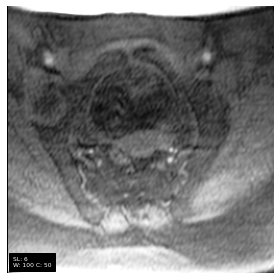

In [11]:
# Show first volume of DCE
experiment['dce'][0].show(level=50, window=100)

In [12]:
# Relative concentration
k = 1
dce_rel = relative_concentration_map(experiment['dce'], experiment['number_baseline'], k, 'abs')
dce_rel.shape

This is computing ABS signal concentration map


(160, 12, 256, 256)

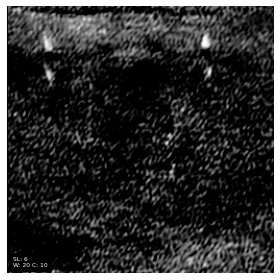

In [13]:
#Plot relative concentration
dce_rel[10].show(level=10, window=20)

### 1st step: select 1% of brightest voxel in first 25 timesteps

In [14]:
def select_brightest_voxels(dce, timesteps, percentile):
    assert timesteps>0 and timesteps<len(dce), "Timesteps {} out of range".format(timesteps)
    assert 0 < percentile < 100, "Percentile {} out of range".format(percentile)
    dce_sum = (np.sum(dce[:timesteps], axis=0, keepdims=True)/float(timesteps))[0]
    dce_pct = np.percentile(dce_sum, 100-percentile)
    brightest_voxels = dce_sum > dce_pct
    #dce_rgb = dce_sum.to_rgb()
    #dce_rgb[brightest_voxels] = (0xff, 0xff, 0)
    return brightest_voxels

Portion of brightest voxels: 1.0%


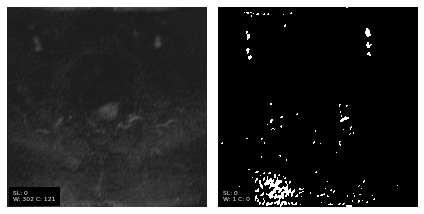

In [15]:
brightest_voxels = select_brightest_voxels(dce_rel, timesteps=20, percentile=1)
print('Portion of brightest voxels: {:.1f}%'.format(100*brightest_voxels.sum() / dce_rel[0].size))
# Show t=20, slice=5 of dce_rel and brightest_voxels
dce_rel[25,5].show(brightest_voxels[5])

### 2nd step: binary opening

In [16]:
def select_binary_opening(voxels):
    # morphological operation of a binary opening
    return scipy.ndimage.binary_opening(voxels)

(12, 256, 256)
Portion of binary opening voxels: 0.2%


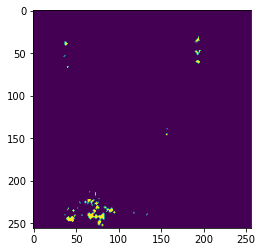

In [17]:
binary_opening = select_binary_opening(brightest_voxels)
print(binary_opening.shape)
print('Portion of binary opening voxels: {:.1f}%'.format(100*binary_opening.sum() / dce_rel[0].size))
fig, ax = plt.subplots(1)
plt.imshow(binary_opening[5])

### 3rd step: find timestep with the most peak values

In [18]:
def find_most_peak_values(dce, mask, timesteps, ax1=None, ax2=None):
    ## Timestep of peak value for every voxel in mask
    peak_values = np.array(np.argmax(dce[:timesteps, mask], axis=0))
    print('find_most_peak_values: peak_values type {}, nonzero {}, size {}, shape {}'.format(type(peak_values), np.count_nonzero(peak_values), peak_values.size, peak_values.shape))

    # Include voxels in first part of timeline only, do not include boundaries
    one_part = timesteps
    first_part_1 = np.bitwise_and(0 < peak_values, peak_values < one_part)
    
    first_part = np.zeros_like(dce[0], dtype=bool)
    first_part[mask] = first_part_1
    print('find_most_peak_values: first_part', first_part.shape, first_part.sum())
    
    # Select most frequent peak timestep
    peak_value = np.argmax(dce[:timesteps, first_part], axis=0)
    hist, edges = np.histogram(peak_value, bins=one_part)
    max_timestep = np.argmax(hist)
    
    print('find_most_peak_values: Max timestep: {}'.format(max_timestep))

    if ax1 is not None:
        #plt.subplot(221)
        ax1.plot(peak_values)
    if ax2 is not None:
        #plt.subplot(222)
        ax2.plot(hist)
        ax2.axvline(max_timestep, color='r')
    
    if max_timestep == 0 or max_timestep >= timesteps-1:
        # Do not include boundaries
        return None, None
    else:
        # Retain found timestep only
        retain_voxels = np.zeros_like(dce[0])
        retain_voxels[mask] = dce[max_timestep, mask]
        return max_timestep, retain_voxels

find_most_peak_values: peak_values type <class 'numpy.ndarray'>, nonzero 1389, size 1389, shape (1389,)
find_most_peak_values: first_part (12, 256, 256) 1389
find_most_peak_values: Max timestep: 0
find_most_peak_values: peak_values type <class 'numpy.ndarray'>, nonzero 1389, size 1389, shape (1389,)
find_most_peak_values: first_part (12, 256, 256) 1389
find_most_peak_values: Max timestep: 28
Portion of retained voxels 1: 0.2%


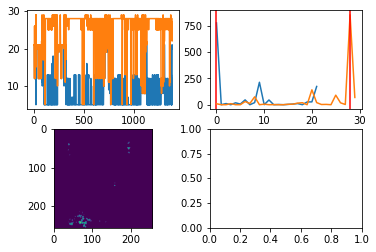

In [19]:
fig, axs = plt.subplots(2, 2)
max_timestep, retain_voxels = find_most_peak_values(dce_rel, binary_opening, timesteps=22, ax1=axs[0, 0], ax2=axs[0, 1])
if max_timestep is None:
    max_timestep, retain_voxels = find_most_peak_values(dce_rel, binary_opening, timesteps=30, ax1=axs[0, 0], ax2=axs[0, 1])
print('Portion of retained voxels 1: {:.1f}%'.format(100*np.count_nonzero(retain_voxels) / dce_rel[0].size))
axs[1,0].imshow(retain_voxels[5])
plt.show()

### 4th step: blob and tube filter

In [162]:
# From binary_opening mask
# Connected component analysis to find objects in the mask, connectivity 18
connectivity = 18

# Skip for now - is intended to locate tubular objects

In [17]:
# For each found object


### 5th step: find timestep with most peak values and compare to result of step 3

### 6th step: fit Parker population AIF

binary_opening (12, 256, 256) bool
label_im (12, 256, 256) int32 32
Regions: 32


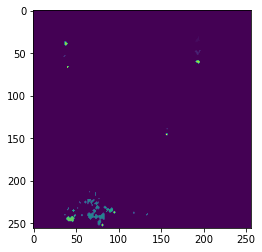

In [20]:
print('binary_opening', binary_opening.shape, binary_opening.dtype)
label_im, num_labels = skimage.measure.label(binary_opening, return_num=True, connectivity=3)

regions = skimage.measure.regionprops(label_im)
print('label_im', label_im.shape, label_im.dtype, num_labels)
print('Regions: {}'.format(len(regions)))
fig, ax = plt.subplots(1, 1)
ax.imshow(label_im[5])
plt.show()

In [21]:
properties = ['area','convex_area','bbox_area', 'extent',
              'mean_intensity', 'solidity' #,'orientation'
    ]
df = pd.DataFrame(skimage.measure.regionprops_table(label_im, binary_opening, 
             properties=properties))
df['area'] = df['area'].apply(lambda x: x*voxel_size)
df.rename(columns = {'area':'area [mm^3]'}, inplace = True)
df

,area [mm^3],convex_area,bbox_area,extent,mean_intensity,solidity
0,645.446777,144,847,0.110980,1.0,0.652778
1,226.593018,39,108,0.305556,1.0,0.846154
2,535.583496,123,450,0.173333,1.0,0.634146
3,82.397461,12,48,0.250000,1.0,1.000000
4,48.065186,7,27,0.259259,1.0,1.000000
5,48.065186,7,27,0.259259,1.0,1.000000
6,48.065186,7,27,0.259259,1.0,1.000000
7,82.397461,12,48,0.250000,1.0,1.000000
8,48.065186,7,27,0.259259,1.0,1.000000
9,48.065186,7,27,0.259259,1.0,1.000000


In [22]:
area_threshold = 100
df[df['area [mm^3]'] > area_threshold]

,area [mm^3],convex_area,bbox_area,extent,mean_intensity,solidity
0,645.446777,144,847,0.110980,1.0,0.652778
1,226.593018,39,108,0.305556,1.0,0.846154
2,535.583496,123,450,0.173333,1.0,0.634146
10,151.062012,22,54,0.407407,1.0,1.000000
12,4195.404053,2249,4800,0.127292,1.0,0.271676
14,116.729736,20,60,0.283333,1.0,0.850000
16,583.648682,173,440,0.193182,1.0,0.491329
17,109.863281,16,48,0.333333,1.0,1.000000
21,913.238525,226,600,0.221667,1.0,0.588496
23,322.723389,49,140,0.335714,1.0,0.959184


In [23]:
def find_promising_objects(regions):
    masks = []
    bbox = []
    list_of_index = []
    for num, x in enumerate(regions):
        area = x.area
        #convex_area = x.convex_area
        #if (num!=0 and (convex_area/area <1.05) and (convex_area/area >0.95)):
        if num!=0 and (area>area_threshold):
            masks.append(regions[num].convex_image)
            bbox.append(regions[num].bbox)   
            list_of_index.append(num)
    return masks, bbox, list_of_index

2
Painting: (12, 256, 256, 3) uint8


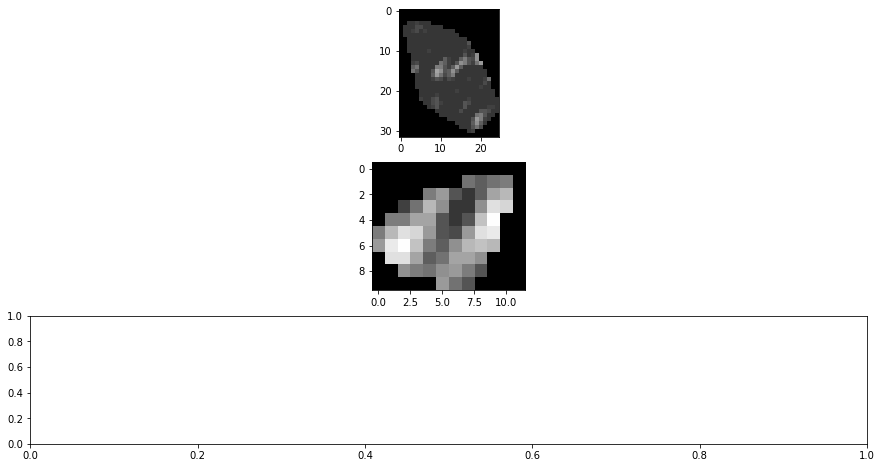

In [24]:
masks, bbox, list_of_index = find_promising_objects(regions)
count = len(masks)
print(count)
val = int(count//3)
if val == 0: 
    val = 1
painting = dce_rel[0].to_rgb()
print('Painting:', painting.shape, painting.dtype)
fig, ax = plt.subplots(3, val, figsize=(15,8))
for axis, box, mask in zip(ax.flatten(), bbox, masks):
    red  =  painting[...,0][box[0]:box[3], box[1]:box[4], box[2]:box[5]] * mask
    green = painting[...,1][box[0]:box[3], box[1]:box[4], box[2]:box[5]] * mask
    blue  = painting[...,2][box[0]:box[3], box[1]:box[4], box[2]:box[5]] * mask
    mid = len(red)//2
    image = Series(np.zeros(red.shape+(3,), dtype=red.dtype))
    image[..., 0] = red
    image[..., 1] = green
    image[..., 2] = blue
    axis.imshow(image[mid]*10)
plt.show()

image (12, 256, 256, 3) uint8


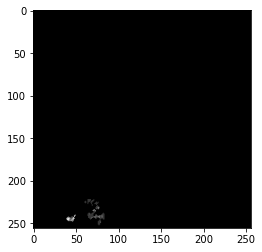

In [25]:
rgb_mask = np.zeros_like(label_im)
for x in list_of_index:
    rgb_mask += (label_im==x+1).astype(int)
red  =  painting[...,0] * rgb_mask
green = painting[...,1] * rgb_mask
blue  = painting[...,2] * rgb_mask
image = dce_rel[0].to_rgb()
print('image', image.shape, image.dtype)
image[..., 0] = red
image[..., 1] = green
image[..., 2] = blue
plt.imshow(image[5]*10)
plt.show()

[12, 21]


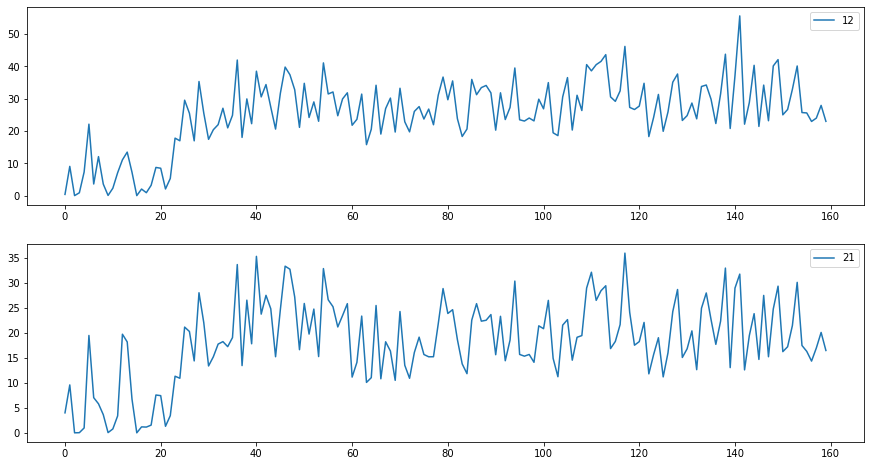

In [26]:
time_course = {}
print(list_of_index)
fig, ax = plt.subplots(len(list_of_index), figsize=(15,8))
for i, x in enumerate(list_of_index):
    rgb_mask = (label_im==x+1).astype(int)
    time_course[x] = np.sum(dce_rel, axis=(1,2,3), where=label_im==x+1)/np.count_nonzero(label_im==x+1)
    show(time_course[x], ax=ax[i], label=x)
plt.show()

In [32]:
def parker(x, N, t):
    # print('parker: x {} '.format(x.shape))
    A1, A2, T1, T2, sigma1, sigma2, alpha, beta, s, tau = x
    # print(A1,A2,T1,T2,sigma1,sigma2,alpha,beta,s,tau)
    '''
    term = np.zeros((3, N))
    term[0] = A1 / sigma1 / math.sqrt(2 * math.pi) * np.exp(-((t - T1) ** 2) / 2 / (sigma1 ** 2))
    term[1] = A2 / sigma2 / math.sqrt(2 * math.pi) * np.exp(-((t - T2) ** 2) / 2 / (sigma2 ** 2))
    term[2] = alpha * np.exp(-beta * t) / (1 + np.exp(-s * (t - tau)))

    # aif = np.sum(term, axis=0) * scaling
    aif = np.sum(term, axis=0)
    # return aif, term[0], term[1], alpha*np.exp(-beta*t), 1/(np.exp(-s*(t-tau)))
    return aif
    '''
    gaussian1 = A1 / (sigma1 * np.sqrt(2 * np.pi))* np.exp(-np.square(t - T1)/(2 * np.square(sigma1)))
    gaussian2 = A2 / (sigma2 * np.sqrt(2 * np.pi))* np.exp(-np.square(t - T2)/(2 * np.square(sigma2)))
    modSigm = (alpha * np.exp(-beta * t)) / (1 + np.exp(-s * (t - tau)))
    Cb = np.add(gaussian1,gaussian2)
    Cb = np.add(Cb, modSigm)#whole blood values
    return Cb

def parker_cost_function(x, t, y):
    return parker(x, y.shape[0], t) - y

def estimate_parkers_model(measured, timeline):
    # timeline in minutes
    norm_factor = max(measured)
    y = measured / norm_factor

    A1 = 0.809
    A2 = 0.33
    T1 = 0.17046
    T2 = 0.365
    sigma1 = 0.0563
    sigma2 = 0.132
    alpha = 1.050
    beta = 0.1685
    s = 38.078
    tau = 0.483

    x0 = np.array((A1, A2, T1, T2, sigma1, sigma2, alpha, beta, s, tau))
    lb = np.array((0, 0, 0.1, 0.2, 1e-9, 1e-9, 1e-3, 0, 0, 0))
    ub = np.array((5, 5, 2, 2, 0.5, 0.7, 5.0, 1.17, 50, 1.5))
    xs = np.array((1, 1, 1, 1, 20, 10, 1, 1, 0.05, 1))
    result = scipy.optimize.least_squares(parker_cost_function, x0, bounds=(lb, ub), x_scale=xs,
                                    args=(timeline, y), verbose=1, ftol=1e-3, xtol=1e-3, gtol=1e-3)
    print('estimate_parkers_model: result.cost: {}'.format(result.cost))
    print('estimate_parkers_model: A1    : {:6.3f} {:6.3f}'.format(x0[0], result.x[0]))
    print('estimate_parkers_model: A2    : {:6.3f} {:6.3f}'.format(x0[1], result.x[1]))
    print('estimate_parkers_model: T1    : {:6.3f} {:6.3f}'.format(x0[2], result.x[2]))
    print('estimate_parkers_model: T2    : {:6.3f} {:6.3f}'.format(x0[3], result.x[3]))
    print('estimate_parkers_model: sigma1: {:6.3f} {:6.3f}'.format(x0[4], result.x[4]))
    print('estimate_parkers_model: sigma2: {:6.3f} {:6.3f}'.format(x0[5], result.x[5]))
    print('estimate_parkers_model: alpha : {:6.3f} {:6.3f}'.format(x0[6], result.x[6]))
    print('estimate_parkers_model: beta  : {:6.3f} {:6.3f}'.format(x0[7], result.x[7]))
    print('estimate_parkers_model: s     : {:6.3f} {:6.3f}'.format(x0[8], result.x[8]))
    print('estimate_parkers_model: tau   : {:6.3f} {:6.3f}'.format(x0[9], result.x[9]))
    return result

Fit time course 12:
`ftol` termination condition is satisfied.
Function evaluations 18, initial cost 5.0512e+01, final cost 7.7210e-01, first-order optimality 1.67e-02.
estimate_parkers_model: result.cost: 0.7721049089894996
estimate_parkers_model: A1    :  0.809  0.050
estimate_parkers_model: A2    :  0.330  0.040
estimate_parkers_model: T1    :  0.170  0.219
estimate_parkers_model: T2    :  0.365  0.519
estimate_parkers_model: sigma1:  0.056  0.056
estimate_parkers_model: sigma2:  0.132  0.050
estimate_parkers_model: alpha :  1.050  0.730
estimate_parkers_model: beta  :  0.169  0.039
estimate_parkers_model: s     : 38.078 10.370
estimate_parkers_model: tau   :  0.483  0.958
solution 0.7721049089894996 True
Fit time course 21:
`ftol` termination condition is satisfied.
Function evaluations 17, initial cost 5.1363e+01, final cost 8.9373e-01, first-order optimality 1.37e-01.
estimate_parkers_model: result.cost: 0.8937348532677198
estimate_parkers_model: A1    :  0.809  0.031
estimate_pa

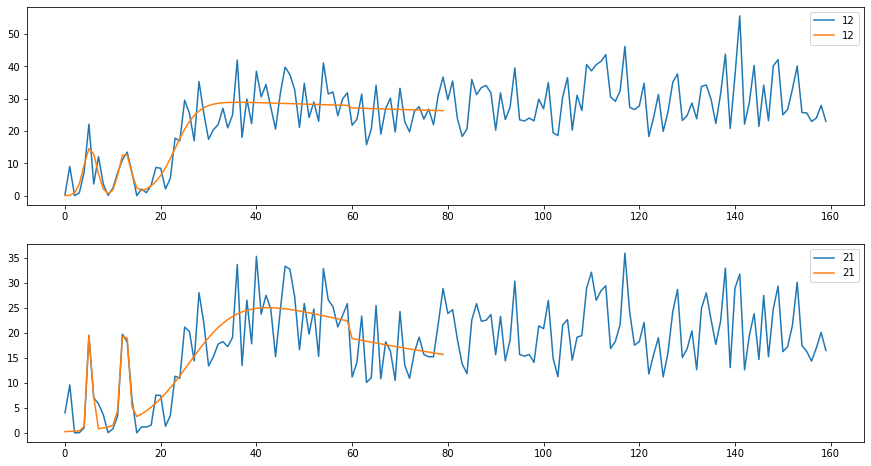

In [33]:
# Fit Parker population AIF
fit = {}
df['cost'] = math.nan
df['T1'] = math.nan
df['T2'] = math.nan
fig, ax = plt.subplots(len(list_of_index), figsize=(15,8))
for i, x in enumerate(list_of_index):
    print('Fit time course {}:'.format(x))
    half = len(dce_rel.timeline)//2
    # solution = estimate_parkers_model(time_course[x], dce_rel.timeline/60)
    solution = estimate_parkers_model(time_course[x][:half], dce_rel.timeline[:half]/60)
    print('solution', solution.cost, solution.success)
    fit[x] = solution
    show(time_course[x], ax=ax[i], label=x)
    t_auc = np.sum(time_course[x][:half])
    p = parker(fit[x].x, half, fit[x].fun.timeline[:half]/60)
    p_auc = np.sum(p)
    show(p*t_auc/p_auc,ax=ax[i], label=x)
    df.at[x, 'cost'] = solution.cost
    df.at[x, 'T1'] = solution.x[2]
    df.at[x, 'T2'] = solution.x[3]
plt.show()

In [34]:
test_timecourses = []# 11, 120]
if len(test_timecourses) > 0:
    fig, ax = plt.subplots(len(test_timecourses), figsize=(15,8))
    for i, x in enumerate(test_timecourses):
        show(time_course[x], ax=ax[i], label=x)
        t_auc = np.sum(time_course[x][:half])
        p = parker(fit[x].x, half, fit[x].fun.timeline[:half]/60)
        p_auc = np.sum(p)
        show(p*t_auc/p_auc,ax=ax[i], label=x)
    plt.show()

In [35]:
df[df['cost'] > 1e-3]

,area [mm^3],convex_area,bbox_area,extent,mean_intensity,solidity,cost,T1,T2
12,4195.404053,2249,4800,0.127292,1.0,0.271676,0.772105,0.219406,0.519172
21,913.238525,226,600,0.221667,1.0,0.588496,0.893735,0.217934,0.518221


In [36]:
i = df['cost'].idxmin()
print(df.iloc[[i]])
best_fit = i
parker_fit_params = df.iloc[[i]]

    area [mm^3]  convex_area  bbox_area    extent  mean_intensity  solidity  \
12  4195.404053         2249       4800  0.127292             1.0  0.271676   

        cost        T1        T2  
12  0.772105  0.219406  0.519172  


### 7th step: erosion and dilation

In [37]:
square = np.array([[1,1,1],
                   [1,1,1],
                   [1,1,1]])

def multi_dil(im, num, element=square):
    for i in range(num):
        im = skimage.morphology.dilation(im, element)
    return im
def multi_ero(im, num, element=square):
    for i in range(num):
        im = skimage.morphology.erosion(im, element)
    return im

<class 'numpy.ndarray'> (12, 256, 256) int32 1
multi_eroded 1
multi_dilated 1


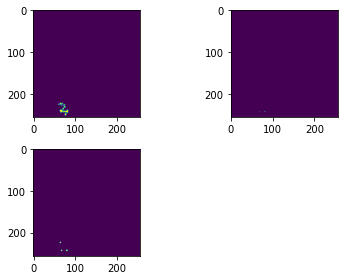

In [38]:
mask = (label_im==best_fit+1).astype(int)
print(type(mask), mask.shape, mask.dtype, mask.max())

#multi_dilated = multi_dil(mask, num=3, element=skimage.morphology.cube(3))
#multi_eroded = multi_ero(multi_dilated, num=3, element=skimage.morphology.cube(3))
multi_eroded = multi_ero(mask, num=1, element=skimage.morphology.cube(3))
multi_dilated = multi_dil(multi_eroded, num=1, element=skimage.morphology.cube(3))
print('multi_eroded', multi_eroded.max())
print('multi_dilated', multi_dilated.max())
plt.subplot(221)
plt.imshow(mask[5]*100)
plt.subplot(222)
plt.imshow(multi_eroded[5]*100)
plt.subplot(223)
plt.imshow(multi_dilated[5]*100)
# mask = multi_eroded
plt.tight_layout()
plt.show()

In [39]:
tc = np.sum(dce_rel, axis=(1,2,3), where=multi_dilated==True)/np.count_nonzero(multi_dilated)
try: 
    solution = estimate_parkers_model(tc[:half], dce_rel.timeline[:half]/60)
    if solution.cost < df['cost'].min():
        print('Selecting dilated mask')
        mask = multi_dilated
        cost_after_dil = solution.cost
    else:
        print('Keeping mask')
        cost_after_dil = df['cost'].min()
except ValueError: 
    print('Keeping mask')
    cost_after_dil = df['cost'].min()


`ftol` termination condition is satisfied.
Function evaluations 12, initial cost 5.0181e+01, final cost 7.3610e-01, first-order optimality 2.56e-02.
estimate_parkers_model: result.cost: 0.7361037063184909
estimate_parkers_model: A1    :  0.809  0.054
estimate_parkers_model: A2    :  0.330  0.041
estimate_parkers_model: T1    :  0.170  0.223
estimate_parkers_model: T2    :  0.365  0.518
estimate_parkers_model: sigma1:  0.056  0.061
estimate_parkers_model: sigma2:  0.132  0.047
estimate_parkers_model: alpha :  1.050  0.757
estimate_parkers_model: beta  :  0.169  0.055
estimate_parkers_model: s     : 38.078  8.604
estimate_parkers_model: tau   :  0.483  0.968
Selecting dilated mask


### 8th step: region growing

In [40]:
def find_brightest_voxel(dce):
    assert dce.ndim == 3, "dce shall be 3-dim, is {}".format(dce.shape)
    _w = np.where(dce == np.max(dce))
    return (int(_w[0]),), (int(_w[1]),), (int(_w[2]),)

mask (12, 256, 256) int32 1 90
seed ((4,), (224,), (64,))
_sum (12, 256, 256) float64
quantile 6.4639999999999995
brightest 7.420000000000002 mean 6.801111111111112 std 0.2613190661260439 threshold 6.539792044985068


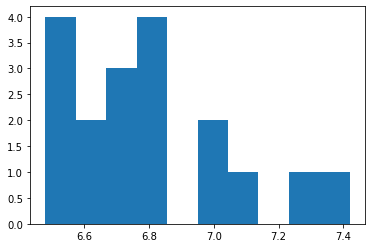

In [41]:
print('mask', mask.shape, mask.dtype, mask.max(), np.count_nonzero(mask))
_sum = np.sum(dce_rel[:10] * mask, axis=0)/10.
seed_point = find_brightest_voxel(_sum)
print('seed', seed_point)
print('_sum', _sum.shape, _sum.dtype)

_sum_in_mask = np.extract(mask==1, _sum)
# print('_sum_in_mask', _sum_in_mask.shape, np.count_nonzero(mask))

brightest_intensity = float(_sum[seed_point])
_quantile = np.quantile(_sum_in_mask, 0.8)
_sum_in_quantile = np.extract(_sum_in_mask>_quantile, _sum_in_mask)
plt.subplots(1, 1)
plt.hist(_sum_in_quantile)
print('quantile', _quantile)
_mean = np.mean(_sum_in_mask, where=_sum_in_mask>_quantile)
_std = np.std(_sum_in_mask, where=_sum_in_mask>_quantile)
threshold = _mean - _std
print('brightest', brightest_intensity, 'mean', _mean, 'std', _std, 'threshold', threshold)
plt.show()

In [42]:
# Flood fill region growing from seed_point with threshold
print('grow: threshold', threshold)
tolerance=brightest_intensity-threshold
print('grow: tolerance', tolerance)
print('grow: seed_point', seed_point)
seed_point=(seed_point[0][0], seed_point[1][0], seed_point[2][0])
print('grow: seed_point', seed_point)
m = skimage.morphology.flood(_sum, seed_point, tolerance=tolerance)

print('grow: m', m.shape, m.dtype, m.max(), np.count_nonzero(m))

grow: threshold 6.539792044985068
grow: tolerance 0.8802079550149333
grow: seed_point ((4,), (224,), (64,))
grow: seed_point (4, 224, 64)
grow: m (12, 256, 256) bool True 4


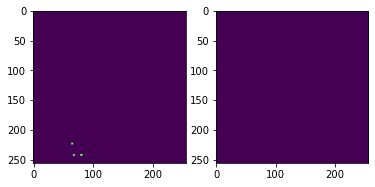

In [43]:
plt.subplots(1, 2)
plt.subplot(121)
plt.imshow(mask[5])
plt.subplot(122)
plt.imshow(m[2])

In [44]:
tc = np.sum(dce_rel, axis=(1,2,3), where=m==True)/np.count_nonzero(m)
solution = estimate_parkers_model(tc[:half], dce_rel.timeline[:half]/60)
print('Cost after region growing: {:.4f}, before region growing: {:.4f}'.format(solution.cost, cost_after_dil))
if solution.cost < cost_after_dil:
    print('Selecting region grow mask')
    mask = m
    cost_after_region_growing = solution.cost
else:
    print('Keeping mask')
    cost_after_region_growing = cost_after_dil 

`ftol` termination condition is satisfied.
Function evaluations 10, initial cost 5.0118e+01, final cost 1.0270e+00, first-order optimality 2.18e-02.
estimate_parkers_model: result.cost: 1.0270165924393038
estimate_parkers_model: A1    :  0.809  0.068
estimate_parkers_model: A2    :  0.330  0.046
estimate_parkers_model: T1    :  0.170  0.223
estimate_parkers_model: T2    :  0.365  0.525
estimate_parkers_model: sigma1:  0.056  0.061
estimate_parkers_model: sigma2:  0.132  0.049
estimate_parkers_model: alpha :  1.050  0.577
estimate_parkers_model: beta  :  0.169  0.000
estimate_parkers_model: s     : 38.078 11.479
estimate_parkers_model: tau   :  0.483  0.948
Cost after region growing: 1.0270, before region growing: 0.7361
Keeping mask


### k-means clustering of time-courses

90


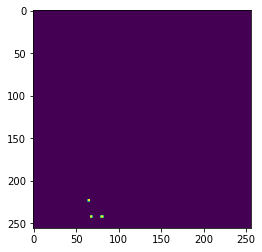

In [45]:
#print(best_fit, label_im.shape)
#mask = (label_im==best_fit+1).astype(int)
#    time_course[x] = np.sum(dce_rel, axis=(1,2,3), where=label_im==x+1)/np.count_nonzero(label_im==x+1)
plt.subplots(1, 1)
plt.imshow(mask[5])
timecourses = []
for s in range(dce_rel.shape[1]):
    for r in range(dce_rel.shape[2]):
        for c in range(dce_rel.shape[3]):
            if mask[s,r,c]:
                timecourses.append(dce_rel[:,s,r,c])
print(len(timecourses))
plt.show()

In [46]:
from sklearn.cluster import KMeans
def kmeans_cluster(df, n_clusters=2):
    """k-means cluster a given data frame into a specified number of
    clusters.
    It will then return a copy of the original data frame with those
    clusters appended in a column named Cluster.

    https://www.districtdatalabs.com/data-exploration-with-python-2
    """

    model = KMeans(n_clusters=n_clusters, random_state=1)
    clusters = model.fit_predict(df)
    #cluster_results = df.copy()
    #cluster_results['Cluster'] = clusters
    #return cluster_results
    return clusters

In [47]:
def summarize_clustering(results):
    """Count the number of objects that fall into each cluster and
    calculate the cluster means for each feature.
    It is going to merge the counts and means into a single data frame
    and then return that summary to us.

    https://www.districtdatalabs.com/data-exploration-with-python-2
    """

    cluster_size = results.groupby(['Cluster']).size().reset_index()
    cluster_size.columns = ['Cluster', 'Count']
    cluster_means = results.groupby(['Cluster'], as_index=False).mean()
    cluster_summary = pd.merge(cluster_size, cluster_means, on='Cluster')
    return cluster_summary

In [48]:
cluster_results = kmeans_cluster(timecourses, 5)
number_of_clusters = cluster_results.max()+1
print(len(cluster_results), number_of_clusters)
hist, edges = np.histogram(cluster_results, range=(0,number_of_clusters), bins=number_of_clusters)
print(hist)
print(edges)
#cluster_summary = summarize_clustering(cluster_results)
#cluster_summary

90 5
[29 22  9 17 13]
[0. 1. 2. 3. 4. 5.]


In [49]:
tc = {}
idx = {}
for x in range(number_of_clusters):
    tc[x] = np.empty([hist[x],dce_rel.shape[0]], dtype=dce_rel.dtype)
    print(x, tc[x].shape)
    idx[x] = 0
i = 0
cmask = np.zeros_like(dce_rel[0], dtype=int)
for s in range(dce_rel.shape[1]):
    for r in range(dce_rel.shape[2]):
        for c in range(dce_rel.shape[3]):
            if mask[s,r,c]:
                cluster = cluster_results[i]
                ind = idx[cluster]
                tc[cluster][ind,:] = dce_rel[:,s,r,c]
                cmask[s,r,c] = cluster+1
                idx[cluster] += 1
                i +=1
# Average clusters
tcc = {}
baseline = np.zeros(number_of_clusters)
fullline = np.zeros(number_of_clusters)
for x in range(number_of_clusters):
    assert idx[x] == hist[x], "idx {} disagree with hist {}".format(idx[x], hist[x])
    tcc[x] = np.sum(tc[x], axis=0)/tc[x].shape[0]
    b = experiment['number_baseline']
    baseline[x] = np.sum(tcc[x][:b])/b
    fullline[x] = np.sum(tcc[x])/len(tcc[x])
best_fit = np.argmin(fullline)
print(best_fit)

0 (29, 160)
1 (22, 160)
2 (9, 160)
3 (17, 160)
4 (13, 160)
1


In [50]:
import matplotlib as mpl
cc = ['r', 'g', 'b', 'c', 'y']
cmap = mpl.colors.ListedColormap(cc)

int32 1


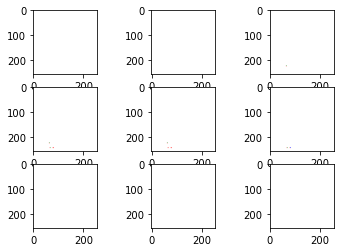

In [51]:
# plt.imshow mask with cluster color
print(mask.dtype, mask.max())
plt.subplots(3, 3)
plt.subplot(331)
plt.imshow(cmask[1], cmap=cmap, alpha=mask[1]*1.0)
plt.subplot(332)
plt.imshow(cmask[2], cmap=cmap, alpha=mask[2]*1.0)
plt.subplot(333)
plt.imshow(cmask[3], cmap=cmap, alpha=mask[3]*1.0)
plt.subplot(334)
plt.imshow(cmask[4], cmap=cmap, alpha=mask[4]*1.0)
plt.subplot(335)
plt.imshow(cmask[5], cmap=cmap, alpha=mask[5]*1.0)
plt.subplot(336)
plt.imshow(cmask[6], cmap=cmap, alpha=mask[6]*1.0)
plt.subplot(337)
plt.imshow(cmask[7], cmap=cmap, alpha=mask[7]*1.0)
plt.subplot(338)
plt.imshow(cmask[8], cmap=cmap, alpha=mask[8]*1.0)
plt.subplot(339)
plt.imshow(cmask[9], cmap=cmap, alpha=mask[9]*1.0)
plt.show()

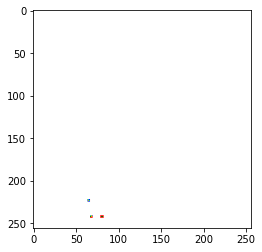

In [52]:
plt.subplots(1, 1)
#plt.imshow(cmask[8], cmap=cmap, alpha=np.float64(mask[8]))
plt.imshow(cmask[5], cmap=cmap, alpha=mask[5]*1.0)
plt.show()

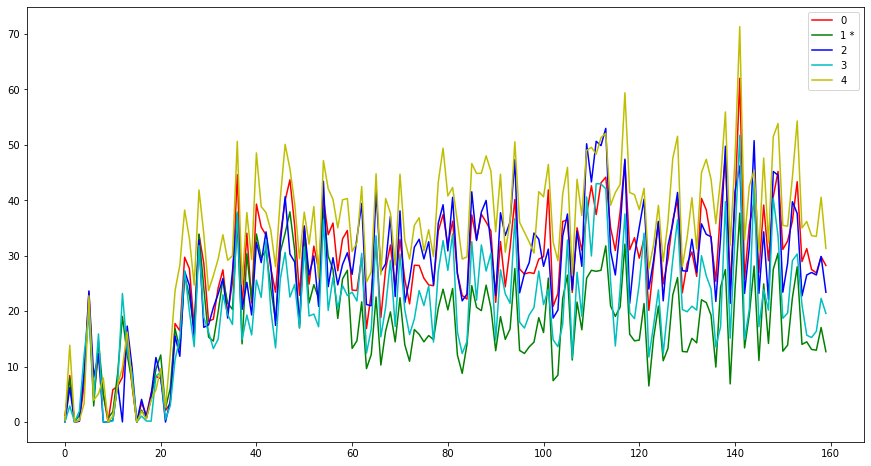

In [53]:
fig, ax = plt.subplots(figsize=(15,8))
for x in range(number_of_clusters):
    if x == best_fit:
        show(tcc[x], ax=ax, label='{} *'.format(x), color=cc[x])
    else:
        show(tcc[x], ax=ax, label=x, color=cc[x])
plt.show()

### Result

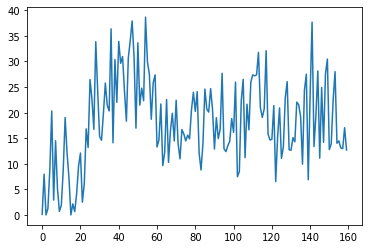

In [54]:
result = best_fit
aif = tcc[best_fit]
show(aif)

In [55]:
timeline = experiment['dce'].timeline

In [56]:
cp = aif/(1-0.42)

In [57]:
from runtofts_fun import *

patient_path = 'H:/data/master endometrial data/170/'
mask_path = os.path.join(patient_path, 'mask')
#vibe_path = os.path.join(patient_path, 'fl3d_vibe_tra_2mm_2min')
#aif_path = os.path.join(patient_path, 'AIF')

mask = Series(mask_path)

read_option = 'mask2dce'
#model_option = 'average'

#Read data 
MASK, DCE, timeline = readdata(mask, experiment['dce'], read_option)

#Subtract pre-contrast signal from signal
DCE = DCE.astype('float32')
S0 = np.mean(DCE[0:5,:,:,:], axis=0)
dynim = DCE.copy()
for k in range(len(timeline)):
    dynim[k,:,:,:] = DCE[k,:,:,:] - S0

#Finding mean concentration inside mask 
non_zero_in_mask = np.nonzero(MASK) #index of nonzero elements in mask image
in_mask_vals = dynim[:, non_zero_in_mask[0], non_zero_in_mask[1], non_zero_in_mask[2]]
C = np.asarray(np.mean(in_mask_vals, axis=1), dtype='float')
opt_params, C_tofts = run_tofts(timeline, C, cp)
    

In [58]:
print(opt_params)

{'Ktrans': 0.0006167097326387466, 've': 0.999999999972409, 'vp': 1.8546559558126892e-15, 'kep': 0.0006167097326557622}


In [207]:
df = parker_fit_params 
df['cost after dilation'] = cost_after_dil 
df['cost after region growing'] = cost_after_region_growing


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.06949427730531103

0.06949427730531103